In [ ]:
#start analysis

C:\Users\ketsa\anaconda3\envs\new_geo_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


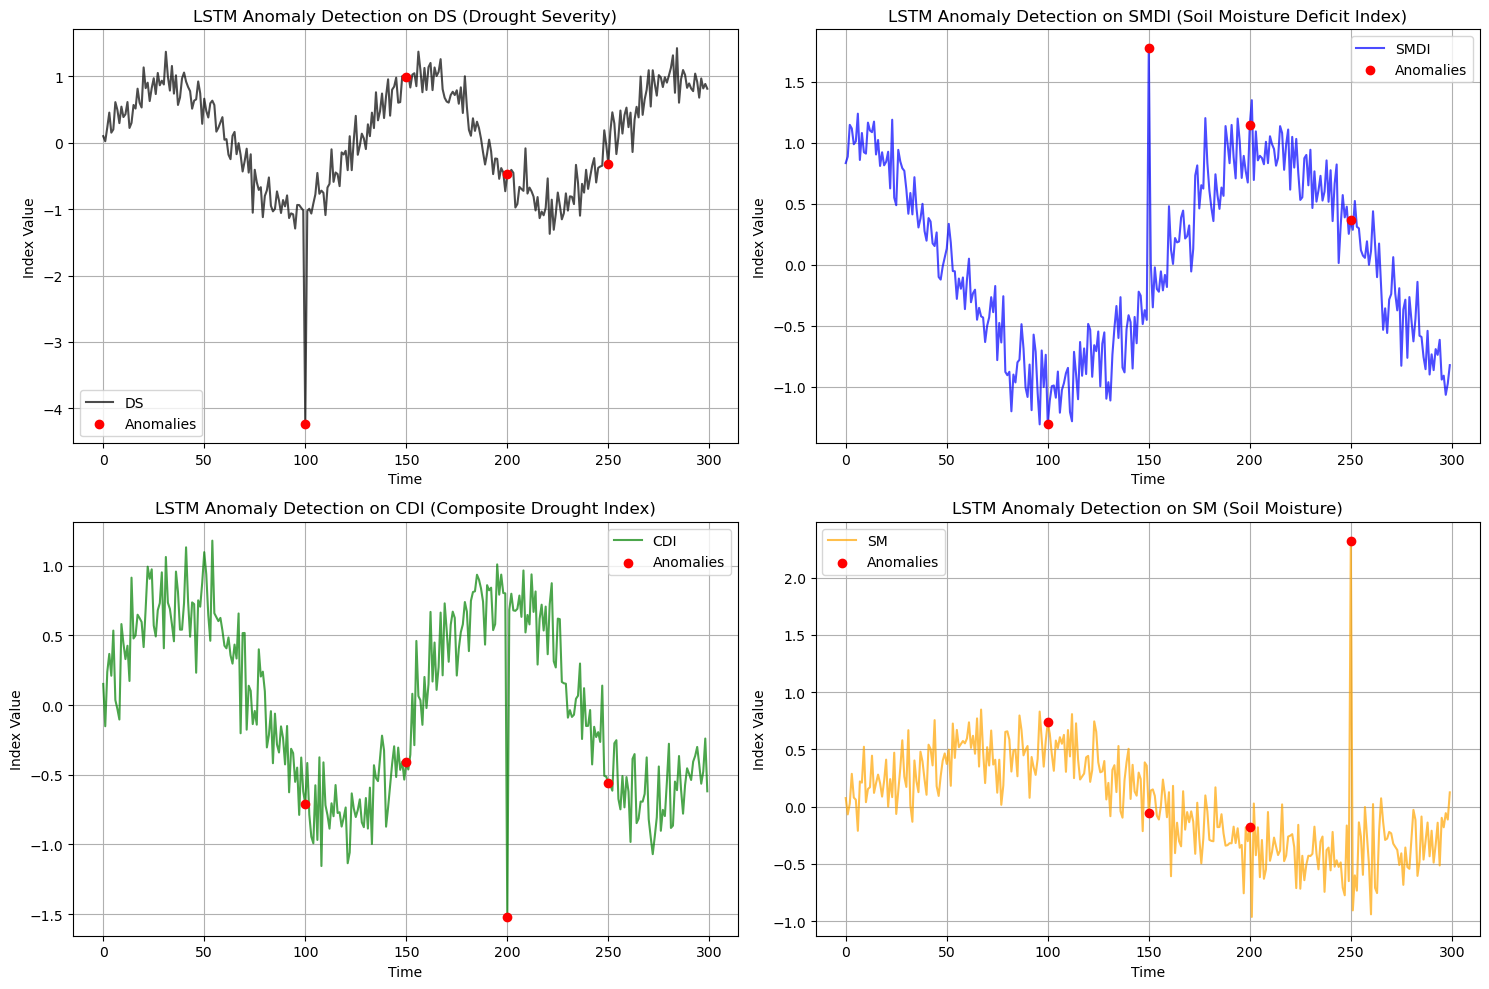

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Set the font to Times New Roman and default font weight to bold
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.size'] = 18  # Set default font size

# --- 1. Generate Synthetic Drought Data ---
np.random.seed(42)
n = 300
t = np.arange(n)

# Simulated normal drought index data
DS = np.sin(t * 0.05) + np.random.normal(0, 0.2, n)
SMDI = np.cos(t * 0.03) + np.random.normal(0, 0.2, n)
CDI = np.sin(t * 0.04) * 0.8 + np.random.normal(0, 0.2, n)
SM = np.sin(t * 0.02) * 0.5 + np.random.normal(0, 0.2, n)

# Insert anomalies (simulate sudden drought drops)
DS[100] -= 3
SMDI[150] += 2
CDI[200] -= 2.5
SM[250] += 3

df = pd.DataFrame({'DS': DS, 'SMDI': SMDI, 'CDI': CDI, 'SM': SM})

# --- 2. Normalize data ---
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# --- 3. Prepare LSTM sequences ---
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

seq_len = 10
X, y = create_sequences(scaled_data, seq_len)

# --- 4. Build and train LSTM ---
model = Sequential([
    LSTM(64, input_shape=(seq_len, 4)),
    Dense(4)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=40, batch_size=16, verbose=0)

# --- 5. Predict and compute reconstruction error ---
y_pred = model.predict(X)
mse = np.mean(np.power(y - y_pred, 2), axis=1)

# --- 6. Set anomaly threshold and detect anomalies ---
threshold = np.mean(mse) + 3 * np.std(mse)
anomalies = mse > threshold
anomaly_indices = np.where(anomalies)[0] + seq_len  # shift by sequence length

# --- 7. Plot results for all variables ---
plt.figure(figsize=(15, 10))

# Plot DS (Drought Severity)
plt.subplot(2, 2, 1)
plt.plot(df['DS'], label='DS', color='black', alpha=0.7)
plt.scatter(anomaly_indices, df['DS'].iloc[anomaly_indices], color='red', label='Anomalies', zorder=5)
plt.title('LSTM Anomaly Detection on DS (Drought Severity)')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.legend()
plt.grid(True)
plt.savefig(r'C:\Users\ketsa\OneDrive\Documents\paper7_drougth\Wavelet\image\LSTM Anomaly Detection on DS (Drought Severity).png', dpi=330)
plt.show()

# Plot SMDI (Soil Moisture Deficit Index)
plt.subplot(2, 2, 2)
plt.plot(df['SMDI'], label='SMDI', color='blue', alpha=0.7)
plt.scatter(anomaly_indices, df['SMDI'].iloc[anomaly_indices], color='red', label='Anomalies', zorder=5)
plt.title('LSTM Anomaly Detection on SMDI (Soil Moisture Deficit Index)')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.legend()
plt.grid(True)
plt.savefig(r'C:\Users\ketsa\OneDrive\Documents\paper7_drougth\Wavelet\image\LSTM Anomaly Detection on SMDI (Soil Moisture Deficit Index).png', dpi=330)
plt.show()

# Plot CDI (Composite Drought Index)
plt.subplot(2, 2, 3)
plt.plot(df['CDI'], label='CDI', color='green', alpha=0.7)
plt.scatter(anomaly_indices, df['CDI'].iloc[anomaly_indices], color='red', label='Anomalies', zorder=5)
plt.title('LSTM Anomaly Detection on CDI (Composite Drought Index)')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.legend()
plt.grid(True)

# Plot SM (Soil Moisture)
plt.subplot(2, 2, 4)
plt.plot(df['SM'], label='SM', color='orange', alpha=0.7)
plt.scatter(anomaly_indices, df['SM'].iloc[anomaly_indices], color='red', label='Anomalies', zorder=5)
plt.title('LSTM Anomaly Detection on SM (Soil Moisture)')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
#final continue add rolling mean and differences as features to improve model performance.

C:\Users\ketsa\anaconda3\envs\new_geo_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


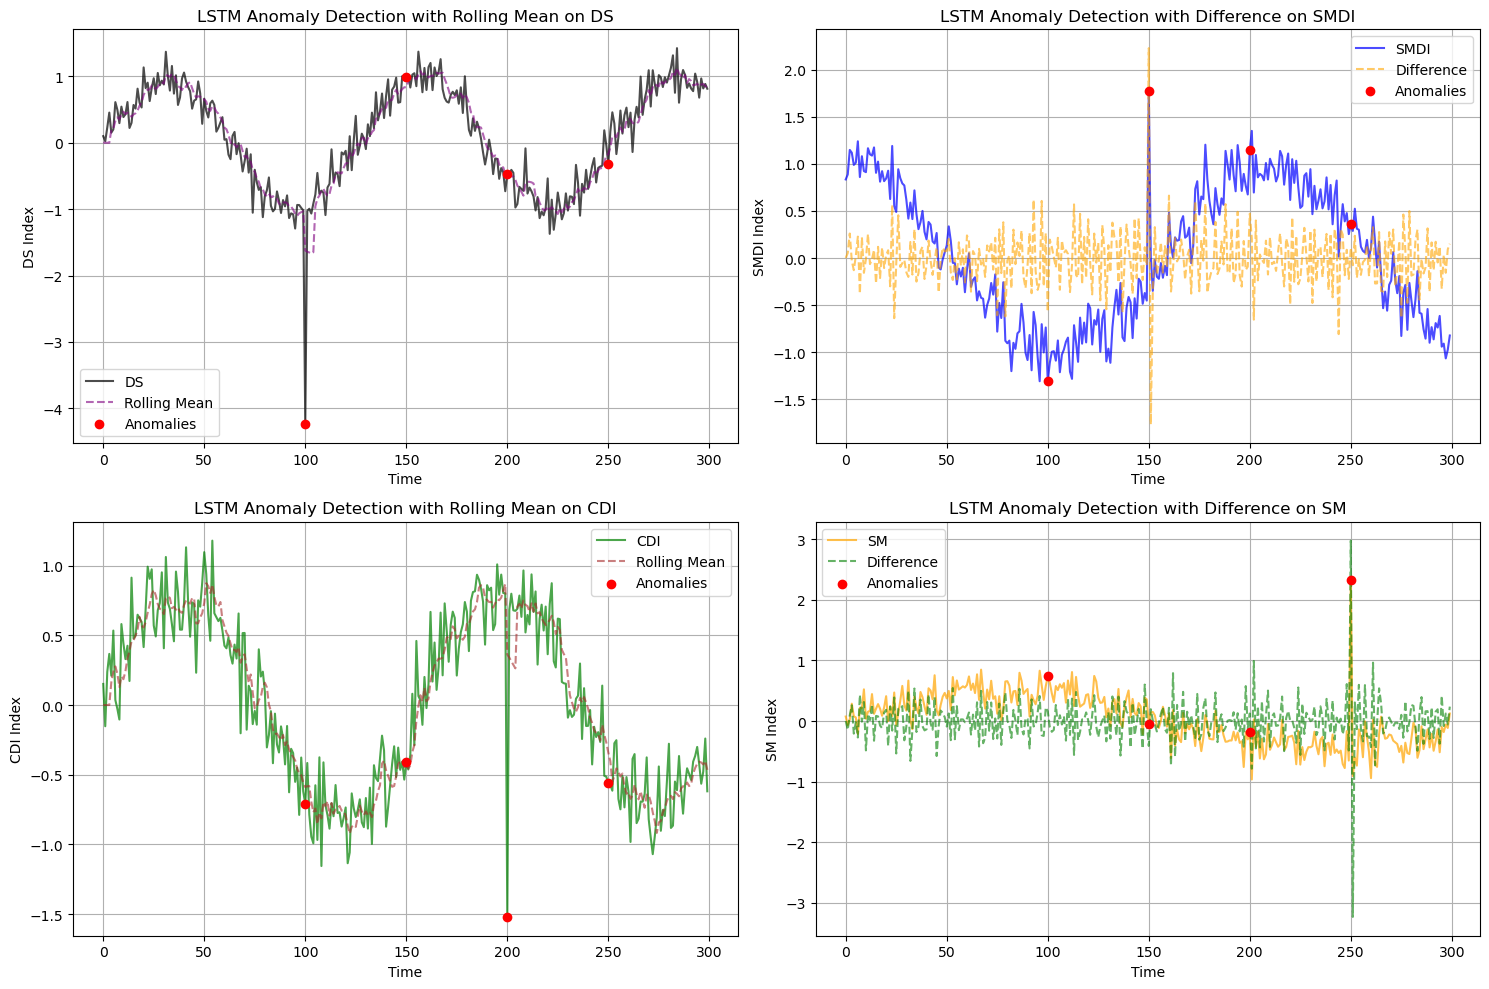

In [2]:
# Adding rolling mean and differences as new features
df['DS_rolling'] = df['DS'].rolling(window=5).mean().fillna(0)
df['SMDI_diff'] = df['SMDI'].diff().fillna(0)
df['CDI_rolling'] = df['CDI'].rolling(window=5).mean().fillna(0)
df['SM_diff'] = df['SM'].diff().fillna(0)

# Re-scale the new dataset
scaled_data_advanced = scaler.fit_transform(df[['DS', 'SMDI', 'CDI', 'SM', 'DS_rolling', 'SMDI_diff', 'CDI_rolling', 'SM_diff']])

# Re-prepare the data sequences
X_advanced, y_advanced = create_sequences(scaled_data_advanced, seq_len)

# Train LSTM on the new data
model_advanced = Sequential([
    LSTM(64, input_shape=(seq_len, X_advanced.shape[2])),
    Dense(8)
])
model_advanced.compile(optimizer='adam', loss='mse')
model_advanced.fit(X_advanced, y_advanced, epochs=40, batch_size=16, verbose=0)

# Predict with the new model
y_pred_advanced = model_advanced.predict(X_advanced)
mse_advanced = np.mean(np.power(y_advanced - y_pred_advanced, 2), axis=1)

# Detect anomalies with the new model
threshold_advanced = np.mean(mse_advanced) + 3 * np.std(mse_advanced)
anomalies_advanced = mse_advanced > threshold_advanced
anomaly_indices_advanced = np.where(anomalies_advanced)[0] + seq_len  # shift by sequence length

# Plot the results with additional features
plt.figure(figsize=(15, 10))

# Plot DS with rolling mean
plt.subplot(2, 2, 1)
plt.plot(df['DS'], label='DS', color='black', alpha=0.7)
plt.plot(df['DS_rolling'], label='Rolling Mean', color='purple', linestyle='--', alpha=0.6)
plt.scatter(anomaly_indices_advanced, df['DS'].iloc[anomaly_indices_advanced], color='red', label='Anomalies', zorder=5)
plt.title('LSTM Anomaly Detection with Rolling Mean on DS')
plt.xlabel('Time')
plt.ylabel('DS Index')
plt.legend()
plt.grid(True)

# Plot SMDI with differences
plt.subplot(2, 2, 2)
plt.plot(df['SMDI'], label='SMDI', color='blue', alpha=0.7)
plt.plot(df['SMDI_diff'], label='Difference', color='orange', linestyle='--', alpha=0.6)
plt.scatter(anomaly_indices_advanced, df['SMDI'].iloc[anomaly_indices_advanced], color='red', label='Anomalies', zorder=5)
plt.title('LSTM Anomaly Detection with Difference on SMDI')
plt.xlabel('Time')
plt.ylabel('SMDI Index')
plt.legend()
plt.grid(True)

# Plot CDI with rolling mean
plt.subplot(2, 2, 3)
plt.plot(df['CDI'], label='CDI', color='green', alpha=0.7)
plt.plot(df['CDI_rolling'], label='Rolling Mean', color='brown', linestyle='--', alpha=0.6)
plt.scatter(anomaly_indices_advanced, df['CDI'].iloc[anomaly_indices_advanced], color='red', label='Anomalies', zorder=5)
plt.title('LSTM Anomaly Detection with Rolling Mean on CDI')
plt.xlabel('Time')
plt.ylabel('CDI Index')
plt.legend()
plt.grid(True)

# Plot SM with differences
plt.subplot(2, 2, 4)
plt.plot(df['SM'], label='SM', color='orange', alpha=0.7)
plt.plot(df['SM_diff'], label='Difference', color='green', linestyle='--', alpha=0.6)
plt.scatter(anomaly_indices_advanced, df['SM'].iloc[anomaly_indices_advanced], color='red', label='Anomalies', zorder=5)
plt.title('LSTM Anomaly Detection with Difference on SM')
plt.xlabel('Time')
plt.ylabel('SM Index')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
